📦 Installing libraries...
✅ Installation complete!

📁 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted successfully!

📖 Reading LiDAR file (memory-optimized)
📦 File size: 747.26 MB
✅ Loaded: 1,152,287 points in 15.69s
   Memory: X,Y,Z = 13.2 MB
   Range: X[817585.0..817789.7] Y[1605726.8..1605862.6] Z[274.3..331.9]

📊 Height Statistics
Ground level: 287.71 m
Height range: 274.32 - 331.95 m (span: 57.63 m)
Mean height: 310.24 m

        Ground (0-2 m): 40,023 pts (3.5%)
   Understory (2-10 m): 90,580 pts (7.9%)
   Mid-story (10-20 m): 327,990 pts (28.5%)
        Canopy (>20 m): 693,694 pts (60.2%)

📈 Creating visualizations (reduced samples)...


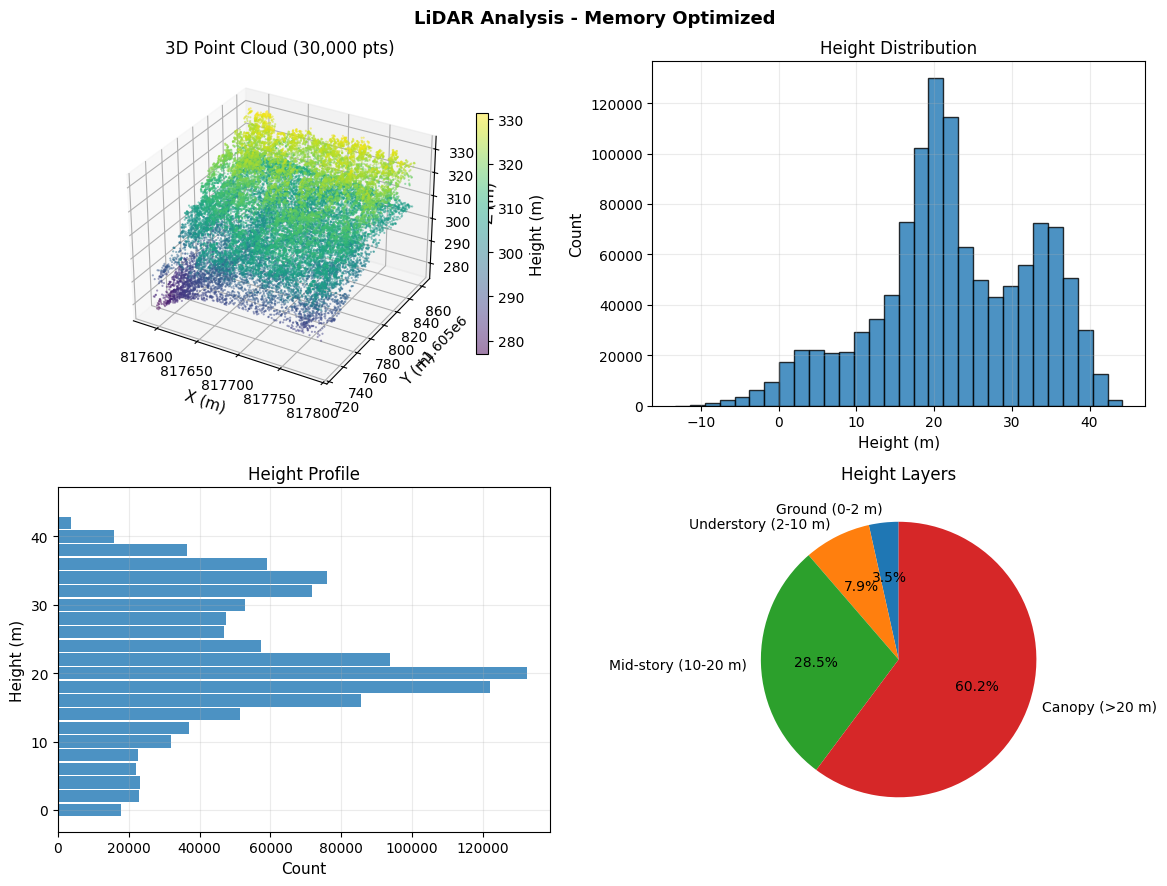


🗺️  Creating CHM...
✅ CHM 136x205 cells (0.1 MB) in 0.92s


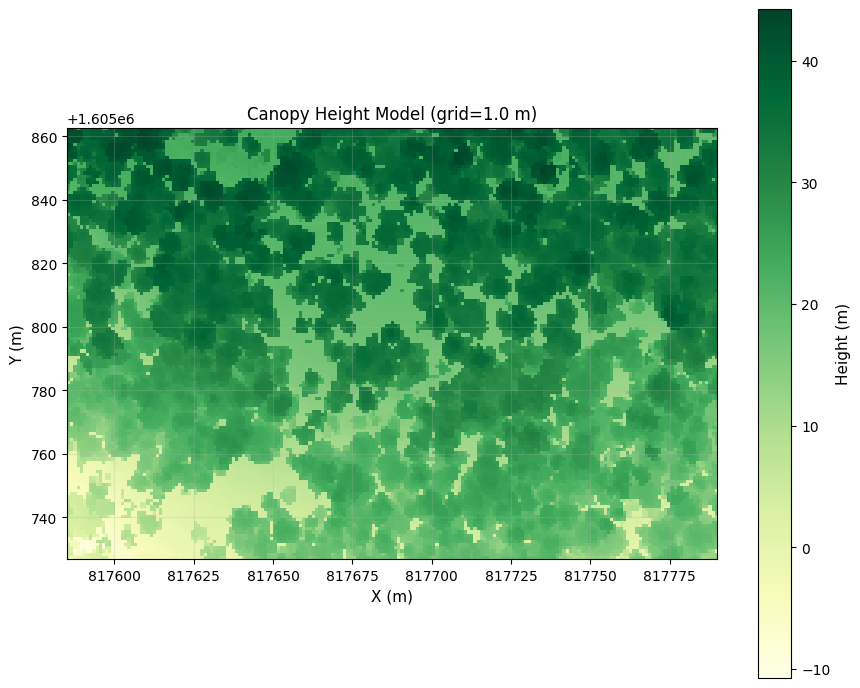


🌳 Tree Segmentation: GRID_CLUSTER
   Grid-based connected components (fastest method)...
   → Found 17 initial regions
   → Filtering 9 tiny regions...
✅ Grid clustering: 8 trees
   💾 Memory used: 0.05 MB

📐 Computing tree metrics...
✅ 8 trees detected

🏆 Top 10 Tallest Trees
------------------------------------------------------------
  ID     Height        Crown          X          Y
------------------------------------------------------------
   2      44.24      26350.0   817707.0  1605852.8
   1      12.81         57.0   817632.0  1605727.8
   5      12.28         91.0   817594.0  1605746.8
   8      10.08          7.0   817610.0  1605743.8
   3      10.04         12.0   817598.0  1605730.8
   4       9.38         19.0   817603.0  1605734.8
   6       8.50         10.0   817606.0  1605742.8
   7       7.64          5.0   817585.0  1605741.8

🎨 Final visualizations...


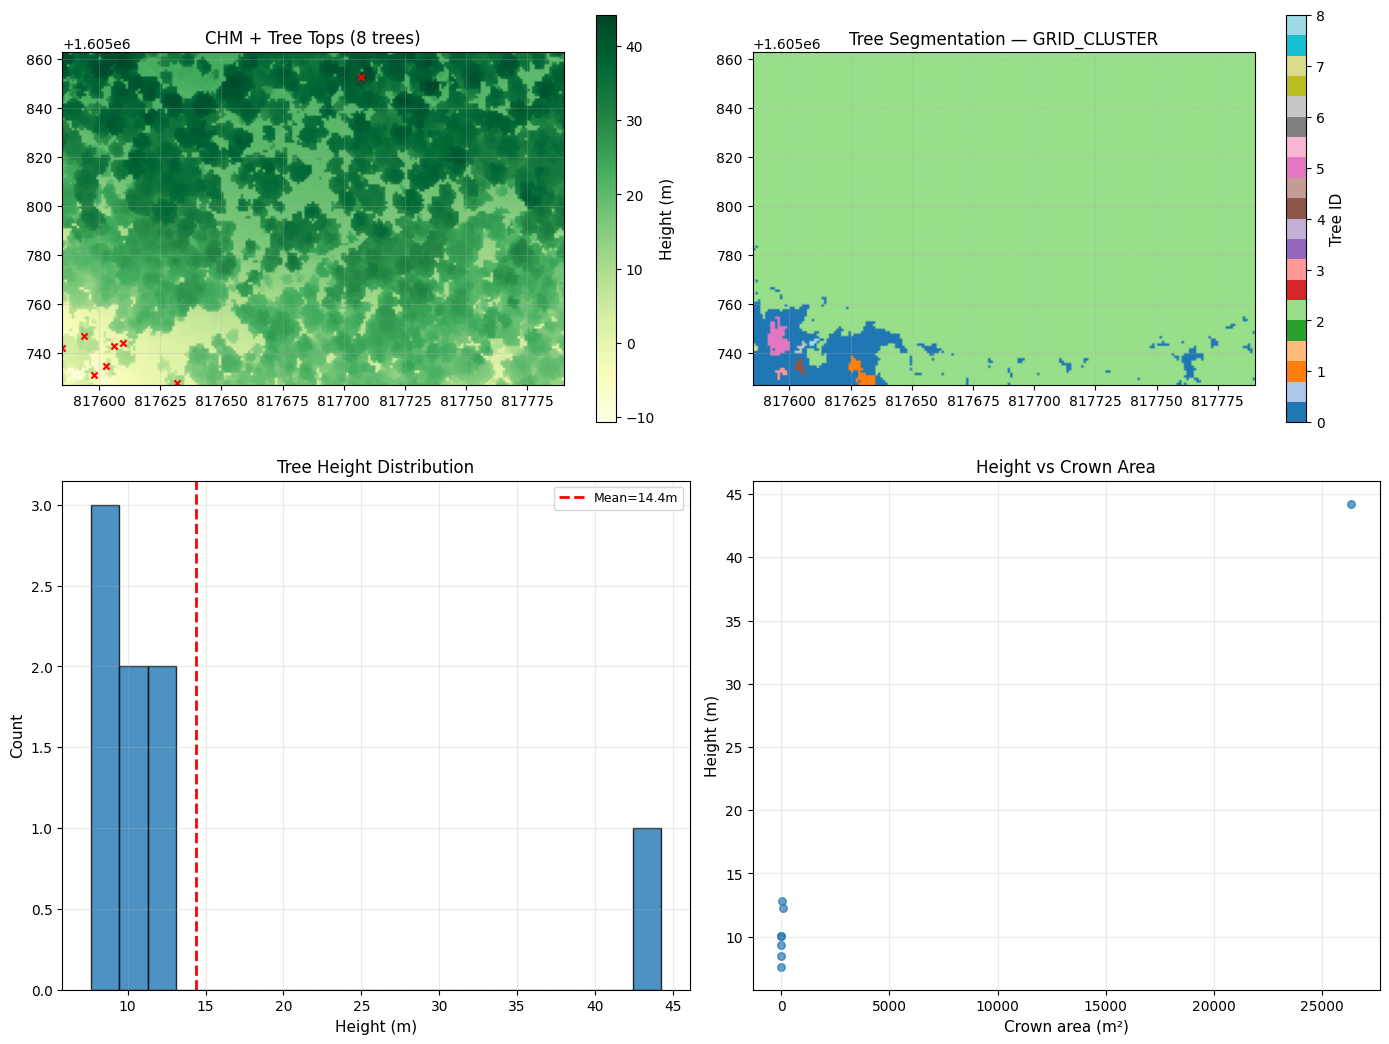


💾 Exporting results (memory-efficient)...
   Assigning tree IDs to points...
✅ Saved LAS: /content/drive/MyDrive/forest_2_trees_classified.las
✅ Saved CSV: /content/drive/MyDrive/forest_2_trees_colored.csv
💾 Analysis report saved: /content/drive/MyDrive/forest_2_analysis.txt
💾 CHM saved (compressed): /content/drive/MyDrive/forest_2_CHM.npz
💾 Tree labels saved (compressed): /content/drive/MyDrive/forest_2_tree_labels.npz
💾 Tree CSV saved: /content/drive/MyDrive/forest_2_trees.csv

✅ Analysis Complete (Memory-Optimized)
🌐 Area: 27811.9 m²
🌲 Trees detected: 8
📊 Mean tree height: 14.37 m
📁 Output: /content/drive/MyDrive
💾 Memory saved: Using float32, compressed exports
🧹 Memory cleaned up!


In [ ]:
"""
LiDAR Tree Analysis
"""

# ===================== Setup & Imports =====================
import numpy as np
import matplotlib.pyplot as plt
import time, os, warnings, gc
warnings.filterwarnings("ignore")

print("📦 Installing libraries...")
!pip install -q laspy[lazrs] scikit-image scipy scikit-learn tqdm

import laspy
from scipy import ndimage
from scipy.stats import binned_statistic_2d
from skimage import feature
from skimage.segmentation import watershed
from sklearn.cluster import DBSCAN, KMeans
from tqdm import tqdm

plt.rcParams.update({
    "figure.dpi": 100,  # ลดจาก 120
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9
})

print("✅ Installation complete!\n")

# ===================== Mount Google Drive =====================
print("📁 Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Drive mounted successfully!\n")

# ===================== Configuration =====================
FILENAME = '/content/drive/MyDrive/forest_2.las'

# ⚡ ULTRA LOW MEMORY MODE
USE_FLOAT32 = True              # ใช้ float32 แทน 64 (ลดแรม 50%)
DOWNSAMPLE_RATIO = 0.05         # 5% - ประหยัดมาก!
EARLY_DOWNSAMPLE = True         # Downsample ทันทีหลังโหลด
MAX_VIZ_POINTS = 30000          # จำกัดจุดใน visualization (ลดลง)

# CHM & Segmentation
GRID_SIZE = 1.0
GROUND_PERCENTILE = 5
MIN_TREE_HEIGHT = 5.0
SEGMENT_METHOD = 'grid_cluster'  # ⭐ เบาสุด เร็วสุด ใช้แค่ ~10 MB!

# DBSCAN params
DBSCAN_EPS_M = 1.5
DBSCAN_MIN_SAMPLES = 20

# KMEANS params
KMEANS_K = None
MAX_KMEANS_K = 3000

# Peak detection
PEAK_MIN_DISTANCE_CELLS = 3
PEAK_THRESHOLD_ABS = MIN_TREE_HEIGHT

# Export
EXPORT_TOP_N_TALLEST = 10

# ===================== Helper Functions =====================
def read_las_points_efficient(path: str, downsample_ratio=None, use_float32=True):
    """
    อ่าน LAS/LAZ แบบประหยัดแรม
    - Downsample ทันทีถ้าต้องการ
    - ใช้ float32 แทน float64
    """
    las = laspy.read(path)

    # Downsample ก่อนแปลงเป็น numpy (ถ้าต้องการ)
    total_points = len(las.points)
    if downsample_ratio and downsample_ratio < 1.0:
        n = int(total_points * downsample_ratio)
        idx = np.random.choice(total_points, n, replace=False)
        # เลือกเฉพาะจุดที่ต้องการ
        X = np.asarray(las.x[idx], dtype=np.float32 if use_float32 else np.float64)
        Y = np.asarray(las.y[idx], dtype=np.float32 if use_float32 else np.float64)
        Z = np.asarray(las.z[idx], dtype=np.float32 if use_float32 else np.float64)
    else:
        X = np.asarray(las.x, dtype=np.float32 if use_float32 else np.float64)
        Y = np.asarray(las.y, dtype=np.float32 if use_float32 else np.float64)
        Z = np.asarray(las.z, dtype=np.float32 if use_float32 else np.float64)

    # ปล่อย las object เพื่อคืนแรม
    del las
    gc.collect()

    return X, Y, Z

def make_chm_fast(X, Y, Z_norm, grid_size):
    """CHM แบบประหยัดแรม - ใช้ float32"""
    x_min, x_max = float(X.min()), float(X.max())
    y_min, y_max = float(Y.min()), float(Y.max())

    nx = int(np.ceil((x_max - x_min) / grid_size))
    ny = int(np.ceil((y_max - y_min) / grid_size))
    x_edges = np.linspace(x_min, x_min + nx*grid_size, nx + 1, dtype=np.float32)
    y_edges = np.linspace(y_min, y_min + ny*grid_size, ny + 1, dtype=np.float32)

    stat, x_e, y_e, _ = binned_statistic_2d(
        X, Y, Z_norm,
        statistic='max',
        bins=[x_edges, y_edges]
    )

    CHM = stat.T.astype(np.float32)
    CHM = np.nan_to_num(CHM, nan=0.0)

    return CHM, x_edges, y_edges

def compute_tree_metrics_from_labels(CHM, labels, x_edges, y_edges, grid_size):
    """คำนวณ metrics แบบประหยัดแรม"""
    tree_data = []
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels > 0]  # ไม่เอา 0 (background)

    for tree_id in unique_labels:
        tree_mask = labels == tree_id
        if not np.any(tree_mask):
            continue

        heights = CHM[tree_mask]
        h_max = float(np.max(heights))
        h_mean = float(np.mean(heights))

        ys, xs = np.where(tree_mask)
        peak_idx = np.argmax(CHM[ys, xs])
        peak_yi, peak_xi = ys[peak_idx], xs[peak_idx]

        real_x = float(x_edges[peak_xi])
        real_y = float(y_edges[peak_yi])
        crown_area = float(np.sum(tree_mask) * (grid_size ** 2))

        tree_data.append({
            "id": int(tree_id),
            "height": h_max,
            "height_mean": h_mean,
            "x": real_x,
            "y": real_y,
            "crown_area": crown_area
        })

        # ลบตัวแปรชั่วคราว
        del tree_mask, heights, ys, xs

    return tree_data

def export_point_products_efficient(base_name, output_dir, X, Y, Z,
                                    labels_grid, x_edges, y_edges, grid_size,
                                    max_points_per_batch=100000):
    """Export แบบ streaming สำหรับไฟล์ใหญ่"""
    nx, ny = labels_grid.shape[1], labels_grid.shape[0]

    # คำนวณ tree_ids ทีละ batch
    print("   Assigning tree IDs to points...")
    n_points = len(X)
    tree_ids = np.zeros(n_points, dtype=np.int32)

    for start in range(0, n_points, max_points_per_batch):
        end = min(start + max_points_per_batch, n_points)
        xi = np.floor((X[start:end] - x_edges[0]) / grid_size).astype(np.int32)
        yi = np.floor((Y[start:end] - y_edges[0]) / grid_size).astype(np.int32)
        xi = np.clip(xi, 0, nx - 1)
        yi = np.clip(yi, 0, ny - 1)
        tree_ids[start:end] = labels_grid[yi, xi]

    num_trees = int(labels_grid.max())
    rng = np.random.default_rng(42)
    colors = np.zeros((num_trees + 1, 3), dtype=np.uint8)
    colors[1:] = rng.integers(0, 255, size=(num_trees, 3), dtype=np.uint8)

    # Export LAS
    las_output = os.path.join(output_dir, f'{base_name}_trees_classified.las')
    try:
        header = laspy.LasHeader(point_format=3, version="1.2")
        header.offsets = np.array([X.min(), Y.min(), Z.min()])
        header.scales = np.array([0.01, 0.01, 0.01])
        las_out = laspy.LasData(header)
        las_out.x, las_out.y, las_out.z = X, Y, Z

        # ทำทีละ batch เพื่อลดแรม
        las_out.red = np.zeros(n_points, dtype=np.uint16)
        las_out.green = np.zeros(n_points, dtype=np.uint16)
        las_out.blue = np.zeros(n_points, dtype=np.uint16)

        for start in range(0, n_points, max_points_per_batch):
            end = min(start + max_points_per_batch, n_points)
            point_colors = colors[tree_ids[start:end]]
            las_out.red[start:end] = point_colors[:, 0].astype(np.uint16) * 256
            las_out.green[start:end] = point_colors[:, 1].astype(np.uint16) * 256
            las_out.blue[start:end] = point_colors[:, 2].astype(np.uint16) * 256

        las_out.classification = tree_ids
        las_out.write(las_output)
        print(f"✅ Saved LAS: {las_output}")
    except Exception as e:
        print(f"⚠️ LAS export failed: {e}")

    # Export CSV แทน PLY (เบาแรมกว่า)
    xyz_output = os.path.join(output_dir, f'{base_name}_trees_colored.csv')
    try:
        with open(xyz_output, 'w') as f:
            f.write("X,Y,Z,R,G,B,TreeID\n")
            for start in range(0, n_points, max_points_per_batch):
                end = min(start + max_points_per_batch, n_points)
                point_colors = colors[tree_ids[start:end]]
                for i in range(start, end):
                    idx = i - start
                    f.write(f"{X[i]:.3f},{Y[i]:.3f},{Z[i]:.3f},"
                           f"{point_colors[idx,0]},{point_colors[idx,1]},{point_colors[idx,2]},"
                           f"{tree_ids[i]}\n")
        print(f"✅ Saved CSV: {xyz_output}")
    except Exception as e:
        print(f"⚠️ CSV export failed: {e}")

    return tree_ids, colors

def save_reports(base_name, output_dir, filename, stats, CHM, labels, tree_data):
    """บันทึก reports แบบประหยัดแรม"""
    os.makedirs(output_dir, exist_ok=True)

    # Text report
    txt = os.path.join(output_dir, f'{base_name}_analysis.txt')
    with open(txt, 'w', encoding='utf-8') as f:
        f.write(f"LiDAR Analysis Report: {os.path.basename(filename)}\n")
        f.write("=" * 60 + "\n\n")
        f.write("=== Basic Information ===\n")
        f.write(f"Total points processed: {stats['n_points']:,}\n")
        f.write(f"Minimum height: {stats['min']:.2f} m\n")
        f.write(f"Maximum height: {stats['max']:.2f} m\n")
        f.write(f"Mean height: {stats['mean']:.2f} m\n")
        f.write(f"Tree height (Z-range): {stats['tree_height']:.2f} m\n\n")

        f.write("=== Height Layer Distribution ===\n")
        for k, v in stats['layers_counts'].items():
            f.write(f"  - {k}: {v['count']:,} points ({v['pct']:.1f}%)\n")
        f.write("\n")

        if len(tree_data) > 0:
            f.write("=== Individual Tree Segmentation ===\n")
            heights = [t['height'] for t in tree_data]
            crown_areas = [t['crown_area'] for t in tree_data]
            f.write(f"Number of trees: {len(tree_data)}\n")
            f.write(f"Mean height: {np.mean(heights):.2f} m\n")
            f.write(f"Min height: {np.min(heights):.2f} m\n")
            f.write(f"Max height: {np.max(heights):.2f} m\n")
            f.write(f"Mean crown area: {np.mean(crown_areas):.2f} m²\n\n")

            f.write("=== Individual Tree Details ===\n")
            f.write(f"{'ID':>4} {'Height (m)':>12} {'Crown Area (m²)':>16} {'X (m)':>10} {'Y (m)':>10}\n")
            f.write("-" * 60 + "\n")
            for tr in tree_data:
                f.write(f"{tr['id']:>4} {tr['height']:>12.2f} {tr['crown_area']:>16.2f} "
                       f"{tr['x']:>10.2f} {tr['y']:>10.2f}\n")

    print(f"💾 Analysis report saved: {txt}")

    # CHM & labels (compress)
    chm_npz = os.path.join(output_dir, f'{base_name}_CHM.npz')
    np.savez_compressed(chm_npz, CHM=CHM.astype(np.float16))  # ใช้ float16 เพื่อประหยัด
    print(f"💾 CHM saved (compressed): {chm_npz}")

    if labels is not None:
        labels_npz = os.path.join(output_dir, f'{base_name}_tree_labels.npz')
        np.savez_compressed(labels_npz, labels=labels.astype(np.uint16))  # ใช้ uint16
        print(f"💾 Tree labels saved (compressed): {labels_npz}")

    # CSV trees
    if len(tree_data) > 0:
        csv = os.path.join(output_dir, f'{base_name}_trees.csv')
        with open(csv, 'w') as f:
            f.write("Tree_ID,Height_m,Height_Mean_m,Crown_Area_m2,X_m,Y_m\n")
            for t in tree_data:
                f.write(f"{t['id']},{t['height']:.2f},{t['height_mean']:.2f},"
                       f"{t['crown_area']:.2f},{t['x']:.2f},{t['y']:.2f}\n")
        print(f"💾 Tree CSV saved: {csv}")

# ===================== 1) Read with early downsampling =====================
print("="*60)
print("📖 Reading LiDAR file (memory-optimized)")
print("="*60)
if not os.path.exists(FILENAME):
    raise FileNotFoundError(f"❌ Not found: {FILENAME}")

file_size_mb = os.path.getsize(FILENAME) / (1024*1024)
print(f"📦 File size: {file_size_mb:.2f} MB")

t0 = time.time()
# อ่านและ downsample ในขั้นตอนเดียว
X, Y, Z = read_las_points_efficient(
    FILENAME,
    downsample_ratio=DOWNSAMPLE_RATIO if EARLY_DOWNSAMPLE else None,
    use_float32=USE_FLOAT32
)
print(f"✅ Loaded: {len(X):,} points in {time.time()-t0:.2f}s")
print(f"   Memory: X,Y,Z = {(X.nbytes + Y.nbytes + Z.nbytes)/(1024**2):.1f} MB")
print(f"   Range: X[{X.min():.1f}..{X.max():.1f}] Y[{Y.min():.1f}..{Y.max():.1f}] Z[{Z.min():.1f}..{Z.max():.1f}]\n")

# ===================== 2) Normalize Height =====================
ground_thresh = np.percentile(Z, GROUND_PERCENTILE)
ground_mask = Z <= ground_thresh
ground_level = float(np.mean(Z[ground_mask]))
Z_norm = Z - ground_level

# Stats
min_h, max_h = float(Z.min()), float(Z.max())
mean_h = float(np.mean(Z))

print("="*60)
print("📊 Height Statistics")
print("="*60)
print(f"Ground level: {ground_level:.2f} m")
print(f"Height range: {min_h:.2f} - {max_h:.2f} m (span: {max_h-min_h:.2f} m)")
print(f"Mean height: {mean_h:.2f} m\n")

# Layer counts
layer_ground = int(np.sum(Z_norm < 2))
layer_under = int(np.sum((Z_norm >= 2) & (Z_norm < 10)))
layer_mid = int(np.sum((Z_norm >= 10) & (Z_norm < 20)))
layer_canopy = int(np.sum(Z_norm >= 20))
total_pts = len(Z_norm)
pct = lambda x: 100.0 * x / total_pts

layers_counts = {
    "Ground (0-2 m)": {"count": layer_ground, "pct": pct(layer_ground)},
    "Understory (2-10 m)": {"count": layer_under, "pct": pct(layer_under)},
    "Mid-story (10-20 m)": {"count": layer_mid, "pct": pct(layer_mid)},
    "Canopy (>20 m)": {"count": layer_canopy, "pct": pct(layer_canopy)}
}
for k, v in layers_counts.items():
    print(f"{k:>22}: {v['count']:,} pts ({v['pct']:.1f}%)")

# ลบตัวแปรที่ไม่ใช้
del ground_mask, ground_thresh
gc.collect()

# ===================== 3) Visualization - แบบประหยัด =====================
print("\n📈 Creating visualizations (reduced samples)...")
fig = plt.figure(figsize=(12, 9))

# 3D scatter - จำกัดจุด
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
n_viz = min(MAX_VIZ_POINTS, len(X))
idx_viz = np.random.choice(len(X), n_viz, replace=False)
p = ax1.scatter(X[idx_viz], Y[idx_viz], Z[idx_viz],
               c=Z[idx_viz], s=0.3, alpha=0.5, cmap='viridis')
ax1.set_title(f"3D Point Cloud ({n_viz:,} pts)")
ax1.set_xlabel("X (m)"); ax1.set_ylabel("Y (m)"); ax1.set_zlabel("Z (m)")
fig.colorbar(p, ax=ax1, label="Height (m)", shrink=0.7)
del idx_viz  # ลบทันที

# Histogram
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(Z_norm, bins=30, edgecolor='black', alpha=0.8)
ax2.set_title("Height Distribution")
ax2.set_xlabel("Height (m)"); ax2.set_ylabel("Count")

# Height profile
ax3 = fig.add_subplot(2, 2, 3)
edges = np.arange(0, np.ceil(Z_norm.max()) + 2, 2)
counts, _ = np.histogram(Z_norm, bins=edges)
ax3.barh(edges[:-1], counts, height=1.8, alpha=0.8)
ax3.set_title("Height Profile")
ax3.set_xlabel("Count"); ax3.set_ylabel("Height (m)")

# Pie
ax4 = fig.add_subplot(2, 2, 4)
labels_pie = list(layers_counts.keys())
sizes = [layers_counts[k]["count"] for k in labels_pie]
ax4.pie(sizes, labels=labels_pie, autopct='%1.1f%%', startangle=90)
ax4.set_title("Height Layers")

plt.suptitle("LiDAR Analysis - Memory Optimized", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()  # ปิด figure เพื่อคืนแรม
gc.collect()

# ===================== 4) CHM =====================
print("\n🗺️  Creating CHM...")
t_chm = time.time()
CHM, x_edges, y_edges = make_chm_fast(X, Y, Z_norm, GRID_SIZE)
print(f"✅ CHM {CHM.shape[0]}x{CHM.shape[1]} cells ({CHM.nbytes/(1024**2):.1f} MB) in {time.time()-t_chm:.2f}s")

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(CHM, origin='lower', cmap='YlGn',
              extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax.set_title(f'Canopy Height Model (grid={GRID_SIZE} m)')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
plt.colorbar(im, ax=ax, label='Height (m)')
plt.tight_layout()
plt.show()
plt.close()
gc.collect()

# ===================== 5) Segmentation =====================
print("\n🌳 Tree Segmentation:", SEGMENT_METHOD.upper())
nx, ny = len(x_edges) - 1, len(y_edges) - 1
labels_grid = np.zeros((ny, nx), dtype=np.uint16)  # ใช้ uint16 แทน int

CHM_smooth = ndimage.gaussian_filter(CHM, sigma=1.0)
mask_canopy = CHM_smooth >= MIN_TREE_HEIGHT

if SEGMENT_METHOD.lower() == 'watershed':
    # Peak detection
    print("   Detecting tree peaks...")
    tmp = CHM_smooth.copy()
    tmp[tmp < PEAK_THRESHOLD_ABS] = -999
    peaks = feature.peak_local_max(tmp, min_distance=PEAK_MIN_DISTANCE_CELLS,
                                   threshold_abs=PEAK_THRESHOLD_ABS)
    markers = np.zeros_like(CHM_smooth, dtype=np.uint16)
    for i, (r, c) in enumerate(peaks, start=1):
        markers[r, c] = i
    markers = ndimage.maximum_filter(markers, size=3)

    print("   Running watershed...")
    labels_grid = watershed(-CHM_smooth, markers, mask=mask_canopy).astype(np.uint16)
    num_trees = int(labels_grid.max())
    print(f"✅ Watershed: {num_trees} trees")
    del tmp, peaks, markers

elif SEGMENT_METHOD.lower() == 'grid_cluster':
    # 🚀 ULTRA FAST & LIGHT - Pure grid-based (NO point cloud clustering!)
    print("   Grid-based connected components (fastest method)...")
    from scipy.ndimage import label as ndimage_label

    # Simple connected components on CHM
    canopy_binary = CHM >= MIN_TREE_HEIGHT
    labels_grid, n_trees = ndimage_label(canopy_binary)
    labels_grid = labels_grid.astype(np.uint16)
    print(f"   → Found {n_trees} initial regions")

    # Optional: Filter tiny regions (< 5 cells = noise)
    unique, counts = np.unique(labels_grid, return_counts=True)
    small_regions = unique[(counts < 5) & (unique > 0)]
    if len(small_regions) > 0:
        print(f"   → Filtering {len(small_regions)} tiny regions...")
        for small_id in small_regions:
            labels_grid[labels_grid == small_id] = 0

    # Re-number after filtering
    unique = np.unique(labels_grid)
    unique = unique[unique > 0]
    new_labels = np.zeros_like(labels_grid)
    for new_id, old_id in enumerate(unique, start=1):
        new_labels[labels_grid == old_id] = new_id
    labels_grid = new_labels

    num_trees = int(labels_grid.max())
    print(f"✅ Grid clustering: {num_trees} trees")
    print(f"   💾 Memory used: {labels_grid.nbytes/(1024**2):.2f} MB")
    del canopy_binary, unique, counts, new_labels

else:
    raise ValueError(f"Unknown method: {SEGMENT_METHOD}. Use 'grid_cluster' or 'watershed'")

gc.collect()

# ===================== 6) Tree Metrics =====================
print("\n📐 Computing tree metrics...")
tree_data = compute_tree_metrics_from_labels(CHM, labels_grid, x_edges, y_edges, GRID_SIZE)
tree_data_sorted = sorted(tree_data, key=lambda d: d['height'], reverse=True)

print(f"✅ {len(tree_data)} trees detected\n")
print("🏆 Top 10 Tallest Trees")
print("-"*60)
print(f"{'ID':>4} {'Height':>10} {'Crown':>12} {'X':>10} {'Y':>10}")
print("-"*60)
for t in tree_data_sorted[:10]:
    print(f"{t['id']:>4} {t['height']:>10.2f} {t['crown_area']:>12.1f} {t['x']:>10.1f} {t['y']:>10.1f}")

# ===================== 7) Final Visualizations =====================
print("\n🎨 Final visualizations...")
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# CHM + peaks
ax1 = axes[0,0]
im1 = ax1.imshow(CHM, origin='lower', cmap='YlGn',
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax1.set_title(f'CHM + Tree Tops ({num_trees} trees)')
tx = [t['x'] for t in tree_data]; ty = [t['y'] for t in tree_data]
ax1.scatter(tx, ty, marker='x', s=20, c='red', linewidths=1.5)
plt.colorbar(im1, ax=ax1, label="Height (m)", shrink=0.8)

# Segmentation
ax2 = axes[0,1]
im2 = ax2.imshow(labels_grid, origin='lower', cmap='tab20',
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
ax2.set_title(f'Tree Segmentation — {SEGMENT_METHOD.upper()}')
plt.colorbar(im2, ax=ax2, label="Tree ID", shrink=0.8)

# Height histogram
ax3 = axes[1,0]
heights = [t['height'] for t in tree_data]
if heights:
    ax3.hist(heights, bins=20, edgecolor='black', alpha=0.8)
    ax3.axvline(np.mean(heights), ls='--', c='red', lw=2, label=f"Mean={np.mean(heights):.1f}m")
    ax3.legend()
ax3.set_title("Tree Height Distribution")
ax3.set_xlabel("Height (m)"); ax3.set_ylabel("Count")

# Crown vs Height
ax4 = axes[1,1]
crown_areas = [t['crown_area'] for t in tree_data]
if heights:
    ax4.scatter(crown_areas, heights, s=30, alpha=0.7)
ax4.set_title("Height vs Crown Area")
ax4.set_xlabel("Crown area (m²)"); ax4.set_ylabel("Height (m)")

plt.tight_layout()
plt.show()
plt.close()
gc.collect()

# ===================== 8) Export =====================
print("\n💾 Exporting results (memory-efficient)...")
output_dir = os.path.dirname(FILENAME)
base_name = os.path.basename(FILENAME).replace(".las","").replace(".laz","")

tree_ids, colors = export_point_products_efficient(
    base_name, output_dir, X, Y, Z,
    labels_grid, x_edges, y_edges, GRID_SIZE
)

# ===================== 9) Save Reports =====================
stats = {
    "n_points": len(X),
    "min": min_h,
    "max": max_h,
    "mean": mean_h,
    "tree_height": max_h - min_h,
    "layers_counts": layers_counts
}
save_reports(base_name, output_dir, FILENAME, stats, CHM, labels_grid, tree_data)

# ===================== 10) Summary =====================
print("\n" + "="*60)
print("✅ Analysis Complete (Memory-Optimized)")
print("="*60)
area_m2 = (X.max()-X.min()) * (Y.max()-Y.min())
print(f"🌐 Area: {area_m2:.1f} m²")
print(f"🌲 Trees detected: {num_trees}")
if heights:
    print(f"📊 Mean tree height: {np.mean(heights):.2f} m")
print(f"📁 Output: {output_dir}")
print(f"💾 Memory saved: Using float32, compressed exports")
print("="*60)

# Final cleanup
del X, Y, Z, Z_norm, CHM, CHM_smooth, labels_grid, tree_ids, colors
gc.collect()
print("🧹 Memory cleaned up!")